Model for ICU Patients Recovery 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')


import functools
from hyperopt import hp, fmin, Trials, tpe
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report, average_precision_score, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import xgboost as xgb

C:\Users\souka\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



### 2. Exploratory Data analysis

In [2]:
# import data 
path = 'Kaggle_Sirio_Libanes_ICU_Prediction.xlsx'
df = pd.read_excel(path)
df.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [3]:
# shape
print('Rows: {} | Columns: {}'.format(df.shape[0], df.shape[1]))

Rows: 1925 | Columns: 231


In [4]:
# data types 
df.dtypes

PATIENT_VISIT_IDENTIFIER        int64
AGE_ABOVE65                     int64
AGE_PERCENTIL                  object
GENDER                          int64
DISEASE GROUPING 1            float64
                               ...   
RESPIRATORY_RATE_DIFF_REL     float64
TEMPERATURE_DIFF_REL          float64
OXYGEN_SATURATION_DIFF_REL    float64
WINDOW                         object
ICU                             int64
Length: 231, dtype: object

In [5]:
#  categorical features
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(exclude=['object']).columns
print(df[cat_cols].columns)

Index(['AGE_PERCENTIL', 'WINDOW'], dtype='object')




Outside the ICU: 1410
Inside the ICU: 515


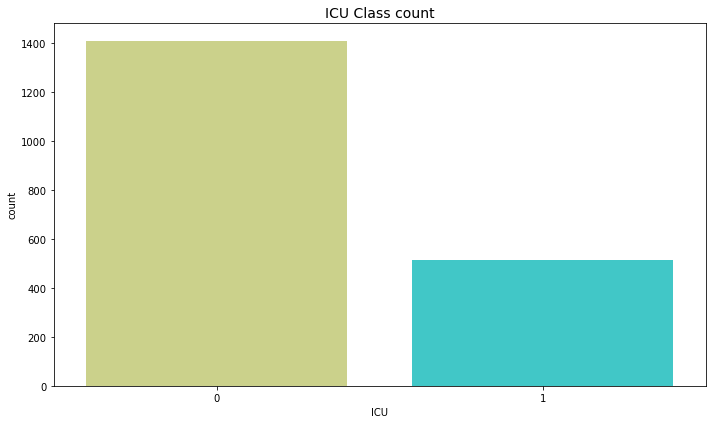

In [57]:
# Label ICU 
plt.figure(figsize=(10,6))
plt.title('ICU Class count', fontsize=14)
sns.countplot(df['ICU'], palette='rainbow_r')
plt.tight_layout()

# count class 

class_1 = len(df[df['ICU']==1])
class_0 = len(df[df['ICU']==0])

# show 
print('\n')
print('Outside the ICU: {}'.format(class_0))
print('Inside the ICU: {}'.format(class_1))

In [7]:
# category aggregation function

def aggregate(df, col, arg, title):
  
  # category values 
  range_1 = len(df[df[col]==arg])
  show = print('{}: {}'.format(title,range_1))
  return show

----- AGE COUNT -----


AGE 10th: 0
AGE 20th: 0
AGE 30th: 0
AGE 40th: 0
AGE 50th: 0
AGE 60th: 0
AGE 70th: 0
AGE 80th: 0
AGE 90th: 0
AGE above 90th: 0


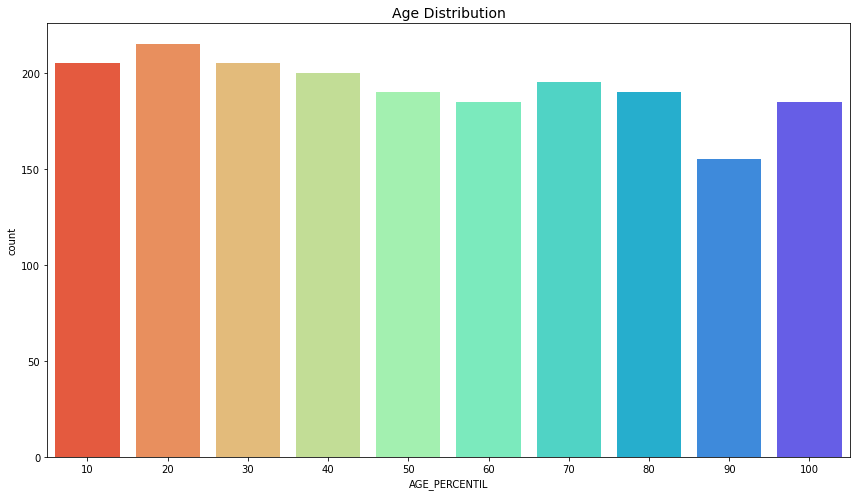

In [58]:
# age distribution
plt.figure(figsize=(12,7))
plt.title('Age Distribution', fontsize=14)
sns.countplot(df['AGE_PERCENTIL'], palette='rainbow_r')
plt.tight_layout()


# Summary ages 
print('----- AGE COUNT -----')
print('\n')
aggregate(df, 'AGE_PERCENTIL', '10th', 'AGE 10th')
aggregate(df, 'AGE_PERCENTIL', '20th', 'AGE 20th')
aggregate(df, 'AGE_PERCENTIL', '30th', 'AGE 30th')
aggregate(df, 'AGE_PERCENTIL', '40th', 'AGE 40th')
aggregate(df, 'AGE_PERCENTIL', '50th', 'AGE 50th')
aggregate(df, 'AGE_PERCENTIL', '60th', 'AGE 60th')
aggregate(df, 'AGE_PERCENTIL', '70th', 'AGE 70th')
aggregate(df, 'AGE_PERCENTIL', '80th', 'AGE 80th')
aggregate(df, 'AGE_PERCENTIL', '90th', 'AGE 90th')
aggregate(df, 'AGE_PERCENTIL', 'Above 90th', 'AGE above 90th')

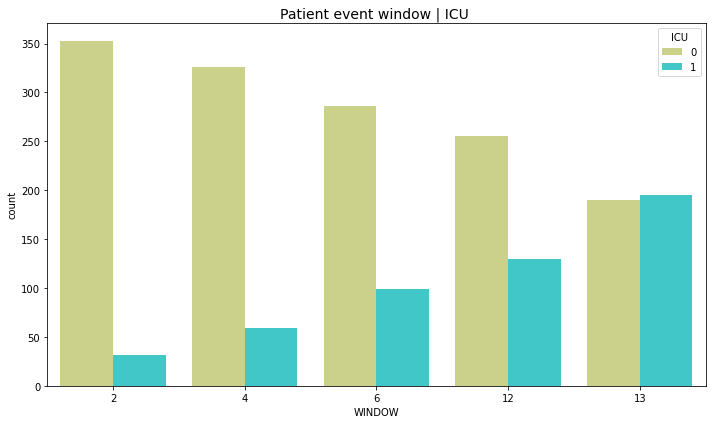

In [59]:
# Patient event window 
plt.figure(figsize=(10,6))
plt.title('Patient event window | ICU ', fontsize=14)
sns.countplot(df['WINDOW'], hue='ICU', data=df, palette='rainbow_r')
plt.tight_layout()

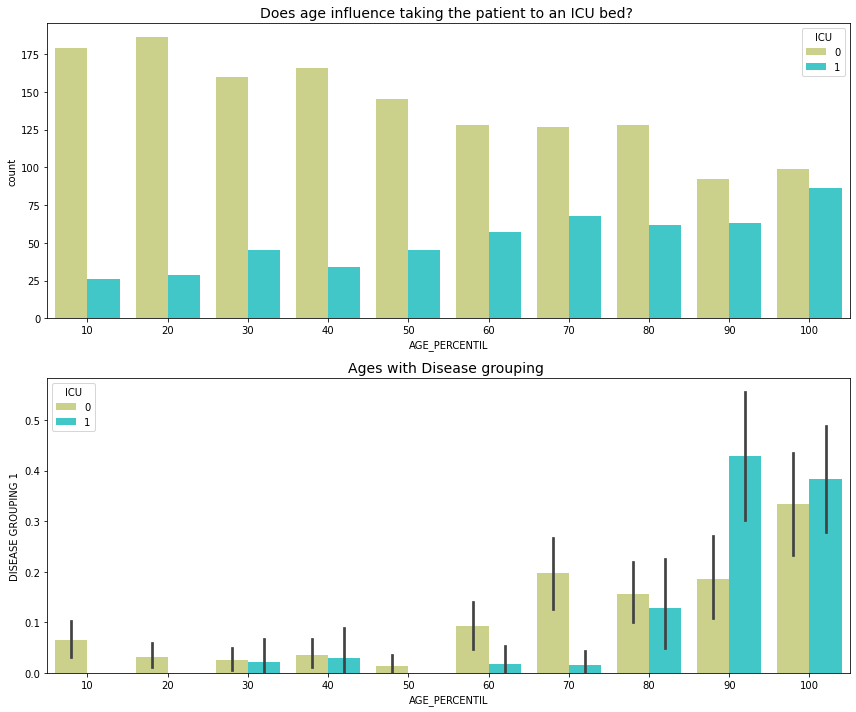

In [60]:
# Does age influence taking the patient to an ICU bed?
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.title('Does age influence taking the patient to an ICU bed? ', fontsize=14)
sns.countplot(df['AGE_PERCENTIL'], hue='ICU', data=df, palette='rainbow_r')

print('\n')

# Ages with Disease Grouping 1
plt.subplot(2,1,2)
plt.title('Ages with Disease grouping ', fontsize=14)
sns.barplot(df['AGE_PERCENTIL'], y='DISEASE GROUPING 1', hue='ICU', data=df, palette='rainbow_r')
plt.tight_layout()

### 3. Feature engineering 

In [11]:
# view mising values 

def missing_values(data):
    
    # Null total 
    missing_values = data.isnull().sum()
    
    # Order nulls 
    total = missing_values.sort_values(ascending=True)
    
    # Percentage  
    percent = (missing_values / len(data.index)*100).round(2).sort_values(ascending=True)

    table_missing = pd.concat([total, percent], axis=1, keys=['Number of Nulls', 'Percentagem of Nulls'])
  
    return table_missing.tail(10)


missing_values(df)

,Number of Nulls,Percentagem of Nulls
INR_MEDIAN,1104,57.35
INR_MEAN,1104,57.35
INR_MIN,1104,57.35
INR_MAX,1104,57.35
INR_DIFF,1104,57.35
LACTATE_MEDIAN,1104,57.35
LACTATE_MEAN,1104,57.35
LACTATE_MIN,1104,57.35
HEMOGLOBIN_MEAN,1104,57.35
P02_VENOUS_MIN,1104,57.35


In [12]:
# input missing values

imp_numeric = SimpleImputer(missing_values=np.nan, strategy='mean')
num_cols = df.select_dtypes(exclude=['object']).columns 


for col in num_cols:
  if df[col].isnull().sum() > 0:
    df[col] = imp_numeric.fit_transform(df[[col]])
  else:
    pass

In [13]:
# handling categorical AGE_PERCENTIL 

def cat_percentil(percentil):
    if percentil == "Above 90th":
        return(100)
    else:
        return(int("".join(c for c in str(percentil) if c.isdigit())))


# checking AGE_PERCENTIL 
df['AGE_PERCENTIL'] = df['AGE_PERCENTIL'].apply(lambda x: cat_percentil(x))
df['AGE_PERCENTIL'].isnull().sum()

0

In [14]:
# handling categorical WINDOW 

def cat_window(window):
    if window == "ABOVE_12":
        return(13)
    else:
        return(int((window.split("-")[1])))


df['WINDOW'] = df['WINDOW'].apply(lambda x: cat_window(x))
df['WINDOW'].isnull().sum()

0

In [15]:
# remove ID 
df.drop('PATIENT_VISIT_IDENTIFIER', axis=1, inplace=True)

### 4. Baseline 

In [16]:
# features | label
X_baseline = df.drop('ICU', axis=1)
y_baseline = df['ICU']


# spliting 
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(X_baseline,y_baseline, test_size=0.30, random_state=42)


# Standard 
scaler = StandardScaler()
X_train_baseline = scaler.fit_transform(X_train_baseline)
X_test_baseline = scaler.transform(X_test_baseline)


# Logistic regression 
baseline = LogisticRegression(random_state=42)
baseline.fit(X_train_baseline, y_train_baseline)
y_pred_baseline = baseline.predict(X_test_baseline)
y_proba_baseline = baseline.predict_proba(X_test_baseline)[:,1]
print(classification_report(y_test_baseline, y_pred_baseline))


# Summary 
print('\n')
print('--------- Baseline Summary ------------')
print('\n')
print('Precision: {}'.format(round(precision_score(y_test_baseline, y_pred_baseline),2)))
print('Recall: {}'.format(round(recall_score(y_test_baseline, y_pred_baseline),2)))
print('AUC: {}'.format(round(roc_auc_score(y_test_baseline, y_proba_baseline),2)))
print('Precision-Recall: {}'.format(round(average_precision_score(y_test_baseline, y_proba_baseline),2)))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       413
           1       0.84      0.56      0.67       165

    accuracy                           0.84       578
   macro avg       0.84      0.76      0.78       578
weighted avg       0.84      0.84      0.83       578



--------- Baseline Summary ------------


Precision: 0.84
Recall: 0.56
AUC: 0.84
Precision-Recall: 0.76


### 5. Feature Selection

In [17]:
# feature selector function 

def feature_selection(k_value=2, name='RandomForest', model=XGBClassifier(random_state=42)):

  # number features 
  k=k_value 
  f_class = functools.partial(f_classif)


  # features | label 
  X = df.drop('ICU', axis=1)
  y = df['ICU']


  # spliting 
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)


  # filter  
  seletor = SelectKBest(score_func=f_class, k=k)
  X_train2 = seletor.fit_transform(X_train, y_train)
  X_test2 = seletor.transform(X_test)


  # Random Forest  
  mdl = model
  mdl.fit(X_train2, y_train)
  y_pred = mdl.predict(X_test2)
  y_proba = mdl.predict_proba(X_test2)[:,1]


  # metrics 
  accuracy = round(accuracy_score(y_test, y_pred),2)
  precision = round(precision_score(y_test, y_pred),2)
  recall = round(recall_score(y_test, y_pred),2)
  precision_recall = round(average_precision_score(y_test, y_proba),2)
  auc = round(roc_auc_score(y_test, y_proba),2)
  

  print('K: {} | Acurácia: {}'.format(k, accuracy))
  print('K: {} | Precision: {}'.format(k, precision))
  print('K: {} | Recall: {}'.format(k, recall))
  print('K: {} | Precision-Recall: {}'.format(k, precision_recall))
  print('K: {} | AUC: {}'.format(k, auc))
  print('\n')
  print('\n')

  mask = seletor.get_support()
  best_features = X.columns[mask]
  print('----- Best {} features {} --------'.format(k, name))
  print('\n')
  print(best_features)

In [18]:
# Features for XGBoost 
feature_selection(k_value=50, name='XGBoost', model=XGBClassifier(random_state=42))

K: 50 | Acurácia: 0.85
K: 50 | Precision: 0.8
K: 50 | Recall: 0.64
K: 50 | Precision-Recall: 0.81
K: 50 | AUC: 0.88




----- Best 50 features XGBoost --------


Index(['AGE_ABOVE65', 'AGE_PERCENTIL', 'ALBUMIN_MIN', 'ALBUMIN_MAX',
       'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN',
       'BE_ARTERIAL_MAX', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN',
       'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'HEMATOCRITE_MEDIAN',
       'HEMATOCRITE_MEAN', 'HEMATOCRITE_MIN', 'HEMATOCRITE_MAX',
       'HEMOGLOBIN_MEDIAN', 'HEMOGLOBIN_MEAN', 'HEMOGLOBIN_MIN',
       'HEMOGLOBIN_MAX', 'LACTATE_MEDIAN', 'LACTATE_MEAN', 'LACTATE_MIN',
       'LACTATE_MAX', 'LEUKOCYTES_MEDIAN', 'LEUKOCYTES_MEAN', 'LEUKOCYTES_MIN',
       'LEUKOCYTES_MAX', 'BLOODPRESSURE_DIASTOLIC_MEAN',
       'RESPIRATORY_RATE_MEAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN',
       'RESPIRATORY_RATE_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MIN',
       'TEMPERATURE_MIN', 'BLOODPRESSURE_SISTOLIC_MAX', 'RESPIRATORY_RATE_MAX',
       'OXYGEN_SATURAT

In [19]:
# Features for LightGBM
feature_selection(k_value=50, name='LightGBM', model=XGBClassifier(random_state=42))

K: 50 | Acurácia: 0.85
K: 50 | Precision: 0.8
K: 50 | Recall: 0.64
K: 50 | Precision-Recall: 0.81
K: 50 | AUC: 0.88




----- Best 50 features LightGBM --------


Index(['AGE_ABOVE65', 'AGE_PERCENTIL', 'ALBUMIN_MIN', 'ALBUMIN_MAX',
       'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN',
       'BE_ARTERIAL_MAX', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN',
       'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'HEMATOCRITE_MEDIAN',
       'HEMATOCRITE_MEAN', 'HEMATOCRITE_MIN', 'HEMATOCRITE_MAX',
       'HEMOGLOBIN_MEDIAN', 'HEMOGLOBIN_MEAN', 'HEMOGLOBIN_MIN',
       'HEMOGLOBIN_MAX', 'LACTATE_MEDIAN', 'LACTATE_MEAN', 'LACTATE_MIN',
       'LACTATE_MAX', 'LEUKOCYTES_MEDIAN', 'LEUKOCYTES_MEAN', 'LEUKOCYTES_MIN',
       'LEUKOCYTES_MAX', 'BLOODPRESSURE_DIASTOLIC_MEAN',
       'RESPIRATORY_RATE_MEAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN',
       'RESPIRATORY_RATE_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MIN',
       'TEMPERATURE_MIN', 'BLOODPRESSURE_SISTOLIC_MAX', 'RESPIRATORY_RATE_MAX',
       'OXYGEN_SATURA

In [20]:
# Features for CatBoost
feature_selection(k_value=50, name='CatBoost', model=CatBoostClassifier(iterations=100,
                             loss_function='Logloss',
                             task_type='CPU',
                             random_state=42,
                             verbose=False))

K: 50 | Acurácia: 0.87
K: 50 | Precision: 0.86
K: 50 | Recall: 0.64
K: 50 | Precision-Recall: 0.82
K: 50 | AUC: 0.89




----- Best 50 features CatBoost --------


Index(['AGE_ABOVE65', 'AGE_PERCENTIL', 'ALBUMIN_MIN', 'ALBUMIN_MAX',
       'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN',
       'BE_ARTERIAL_MAX', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN',
       'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'HEMATOCRITE_MEDIAN',
       'HEMATOCRITE_MEAN', 'HEMATOCRITE_MIN', 'HEMATOCRITE_MAX',
       'HEMOGLOBIN_MEDIAN', 'HEMOGLOBIN_MEAN', 'HEMOGLOBIN_MIN',
       'HEMOGLOBIN_MAX', 'LACTATE_MEDIAN', 'LACTATE_MEAN', 'LACTATE_MIN',
       'LACTATE_MAX', 'LEUKOCYTES_MEDIAN', 'LEUKOCYTES_MEAN', 'LEUKOCYTES_MIN',
       'LEUKOCYTES_MAX', 'BLOODPRESSURE_DIASTOLIC_MEAN',
       'RESPIRATORY_RATE_MEAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN',
       'RESPIRATORY_RATE_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MIN',
       'TEMPERATURE_MIN', 'BLOODPRESSURE_SISTOLIC_MAX', 'RESPIRATORY_RATE_MAX',
       'OXYGEN_SATUR

### 6. Tuning Hyperparameters 


#### Tuning XGBoost

<br>

In [21]:
# TOP 50 features XGBoost 
xgb_columns = df[['AGE_ABOVE65', 'AGE_PERCENTIL', 'ALBUMIN_MIN', 'ALBUMIN_MAX',
       'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN',
       'BE_ARTERIAL_MAX', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN',
       'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'HEMATOCRITE_MEDIAN',
       'HEMATOCRITE_MEAN', 'HEMATOCRITE_MIN', 'HEMATOCRITE_MAX',
       'HEMOGLOBIN_MEDIAN', 'HEMOGLOBIN_MEAN', 'HEMOGLOBIN_MIN',
       'HEMOGLOBIN_MAX', 'LACTATE_MEDIAN', 'LACTATE_MEAN', 'LACTATE_MIN',
       'LACTATE_MAX', 'LEUKOCYTES_MEDIAN', 'LEUKOCYTES_MEAN', 'LEUKOCYTES_MIN',
       'LEUKOCYTES_MAX', 'BLOODPRESSURE_DIASTOLIC_MEAN',
       'RESPIRATORY_RATE_MEAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN',
       'RESPIRATORY_RATE_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MIN',
       'TEMPERATURE_MIN', 'BLOODPRESSURE_SISTOLIC_MAX', 'RESPIRATORY_RATE_MAX',
       'OXYGEN_SATURATION_MAX', 'BLOODPRESSURE_DIASTOLIC_DIFF',
       'BLOODPRESSURE_SISTOLIC_DIFF', 'HEART_RATE_DIFF',
       'RESPIRATORY_RATE_DIFF', 'TEMPERATURE_DIFF', 'OXYGEN_SATURATION_DIFF',
       'BLOODPRESSURE_DIASTOLIC_DIFF_REL', 'BLOODPRESSURE_SISTOLIC_DIFF_REL',
       'HEART_RATE_DIFF_REL', 'RESPIRATORY_RATE_DIFF_REL',
       'TEMPERATURE_DIFF_REL', 'OXYGEN_SATURATION_DIFF_REL', 'WINDOW', 'ICU']]


X = xgb_columns.drop('ICU', axis=1)
y = df['ICU']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)

mdl = XGBClassifier(random_state=42)
mdl.fit(X_train, y_train)
y_pred = mdl.predict(X_test)
y_proba = mdl.predict_proba(X_test)[:,1]


# objective function 
def objective(params):
  return -average_precision_score(y_test, y_proba)

In [22]:
#probability of distribution of parameters

spaces_xgboost = {'n_estimators': hp.randint('n_estimators', 1200),
          'learning_rate': hp.loguniform('learning_rate', 1e-5, 1e-1),
          'max_depth': hp.randint('max_depth', 30),
          'min_child_weight': hp.uniform('min_child_weight', 0,20),
          'reg_lambda': hp.uniform('reg_lambda', 0.001, 3),
          'reg_alpha': hp.uniform('reg_alpha', 0.001, 3),
          'gamma': hp.uniform('gamma', 0,10),
          'max_delta_step': hp.uniform('max_delta_step', 0, 10),
          'max_leaves': hp.randint('max_leaves', 30),
          'colsample_bytree': hp.uniform('colsample_bytree', 0.1,1.0),
          'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
          'scale_pos_weight': hp.randint('scale_pos_weight', 10)}

In [23]:
# Bayesian Optimization 
trials = Trials()
xgboost_tuning = fmin(objective, spaces_xgboost, algo=tpe.suggest, max_evals=100, trials=trials, verbose=1)

100%|█████████████████████████████████████████████| 100/100 [00:01<00:00, 85.69trial/s, best loss: -0.8102000864352001]


In [24]:
# best params 
xgboost_tuning

{'colsample_bylevel': 0.705560792599301,
 'colsample_bytree': 0.4567750093902354,
 'gamma': 6.93398192254275,
 'learning_rate': 1.0144150669053116,
 'max_delta_step': 3.8999845856342397,
 'max_depth': 1,
 'max_leaves': 28,
 'min_child_weight': 18.233666207287403,
 'n_estimators': 732,
 'reg_alpha': 2.411491720049594,
 'reg_lambda': 0.2807892039899411,
 'scale_pos_weight': 2}

In [25]:
# XGBoost tuning
xgboost = XGBClassifier(**xgboost_tuning, random_state=42)
xgboost.fit(X_train, y_train)
y_pred = xgboost.predict(X_test)
y_proba = xgboost.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))


# XGBoost summary 
print('\n')
print('AUC: {}'.format(round(roc_auc_score(y_test, y_proba),2)))
print('Precision-Recall: {}'.format(round(average_precision_score(y_test, y_proba),2)))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       413
           1       0.77      0.72      0.74       165

    accuracy                           0.86       578
   macro avg       0.83      0.81      0.82       578
weighted avg       0.85      0.86      0.85       578



AUC: 0.89
Precision-Recall: 0.82


#### Tuning LightGBM

In [26]:
# TOP 50 features LightGBM 
lightgbm_columns = df[['AGE_ABOVE65', 'AGE_PERCENTIL', 'ALBUMIN_MIN', 'ALBUMIN_MAX',
       'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN',
       'BE_ARTERIAL_MAX', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN',
       'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'HEMATOCRITE_MEDIAN',
       'HEMATOCRITE_MEAN', 'HEMATOCRITE_MIN', 'HEMATOCRITE_MAX',
       'HEMOGLOBIN_MEDIAN', 'HEMOGLOBIN_MEAN', 'HEMOGLOBIN_MIN',
       'HEMOGLOBIN_MAX', 'LACTATE_MEDIAN', 'LACTATE_MEAN', 'LACTATE_MIN',
       'LACTATE_MAX', 'LEUKOCYTES_MEDIAN', 'LEUKOCYTES_MEAN', 'LEUKOCYTES_MIN',
       'LEUKOCYTES_MAX', 'BLOODPRESSURE_DIASTOLIC_MEAN',
       'RESPIRATORY_RATE_MEAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN',
       'RESPIRATORY_RATE_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MIN',
       'TEMPERATURE_MIN', 'BLOODPRESSURE_SISTOLIC_MAX', 'RESPIRATORY_RATE_MAX',
       'OXYGEN_SATURATION_MAX', 'BLOODPRESSURE_DIASTOLIC_DIFF',
       'BLOODPRESSURE_SISTOLIC_DIFF', 'HEART_RATE_DIFF',
       'RESPIRATORY_RATE_DIFF', 'TEMPERATURE_DIFF', 'OXYGEN_SATURATION_DIFF',
       'BLOODPRESSURE_DIASTOLIC_DIFF_REL', 'BLOODPRESSURE_SISTOLIC_DIFF_REL',
       'HEART_RATE_DIFF_REL', 'RESPIRATORY_RATE_DIFF_REL',
       'TEMPERATURE_DIFF_REL', 'OXYGEN_SATURATION_DIFF_REL', 'WINDOW', 'ICU']]


X = lightgbm_columns.drop('ICU', axis=1)
y = df['ICU']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)


# objective function 
def objective(params):
  return -average_precision_score(y_test, y_proba)

In [27]:
#probability of distribution of parameters

spaces_lightgbm = {'n_estimators': hp.randint('n_estimators', 1000),
          'num_leaves': hp.randint('num_leaves', 100),
          'learning_rate': hp.loguniform('learning_rate', 1e-5, 1e-1),
          'max_depth': hp.randint('max_depth', 30),
          'min_child_samples': hp.uniform('min_child_samples', 0,20),
          'lambda_l1': hp.uniform('lambda_l1', 0.001, 3),
          'lambda_l2': hp.uniform('lambda_l2', 0.001, 3),
          'min_data_in_leaf': hp.randint('min_data_in_leaf', 40)}

In [28]:
# Bayesian Optimization 
trials = Trials()
lightgbm_tuning = fmin(objective, spaces_lightgbm, algo=tpe.suggest, max_evals=100, trials=trials, verbose=1)

100%|████████████████████████████████████████████| 100/100 [00:00<00:00, 141.49trial/s, best loss: -0.8174503408604327]


In [29]:
# best params LightGBM 
lightgbm_tuning

{'lambda_l1': 1.3230777391579789,
 'lambda_l2': 0.5562461490541042,
 'learning_rate': 1.0324791921516059,
 'max_depth': 4,
 'min_child_samples': 10.89925041045941,
 'min_data_in_leaf': 10,
 'n_estimators': 390,
 'num_leaves': 61}

In [30]:
# LightGBM tuning
lightgbm = LGBMClassifier(**lightgbm_tuning, seed=42)
lightgbm.fit(X_train, y_train)
y_pred = xgboost.predict(X_test)
y_proba = lightgbm.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))


# LightGBM summary 
print('\n')
print('AUC: {}'.format(round(roc_auc_score(y_test, y_proba),2)))
print('Precision-Recall: {}'.format(round(average_precision_score(y_test, y_proba),2)))

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10.89925041045941 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=1.3230777391579789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3230777391579789
[LightGBM] [Warning] lambda_l2 is set=0.5562461490541042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5562461490541042
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10.89925041045941 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=1.3230777391579789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3230777391579789
[LightGBM] [Warning] lambda_l2 is set=0.5562461490541042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5562461490541042
[LightGBM] [Info] Number of positive: 350, number of negative: 997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_co

### Tuning CatBoost 

In [31]:
# TOP 50 features CatBoost  
catboost_columns = df[['AGE_ABOVE65', 'AGE_PERCENTIL', 'ALBUMIN_MIN', 'ALBUMIN_MAX',
       'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN',
       'BE_ARTERIAL_MAX', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN',
       'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'HEMATOCRITE_MEDIAN',
       'HEMATOCRITE_MEAN', 'HEMATOCRITE_MIN', 'HEMATOCRITE_MAX',
       'HEMOGLOBIN_MEDIAN', 'HEMOGLOBIN_MEAN', 'HEMOGLOBIN_MIN',
       'HEMOGLOBIN_MAX', 'LACTATE_MEDIAN', 'LACTATE_MEAN', 'LACTATE_MIN',
       'LACTATE_MAX', 'LEUKOCYTES_MEDIAN', 'LEUKOCYTES_MEAN', 'LEUKOCYTES_MIN',
       'LEUKOCYTES_MAX', 'BLOODPRESSURE_DIASTOLIC_MEAN',
       'RESPIRATORY_RATE_MEAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN',
       'RESPIRATORY_RATE_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MIN',
       'TEMPERATURE_MIN', 'BLOODPRESSURE_SISTOLIC_MAX', 'RESPIRATORY_RATE_MAX',
       'OXYGEN_SATURATION_MAX', 'BLOODPRESSURE_DIASTOLIC_DIFF',
       'BLOODPRESSURE_SISTOLIC_DIFF', 'HEART_RATE_DIFF',
       'RESPIRATORY_RATE_DIFF', 'TEMPERATURE_DIFF', 'OXYGEN_SATURATION_DIFF',
       'BLOODPRESSURE_DIASTOLIC_DIFF_REL', 'BLOODPRESSURE_SISTOLIC_DIFF_REL',
       'HEART_RATE_DIFF_REL', 'RESPIRATORY_RATE_DIFF_REL',
       'TEMPERATURE_DIFF_REL', 'OXYGEN_SATURATION_DIFF_REL', 'WINDOW', 'ICU']]



X = catboost_columns.drop('ICU', axis=1)
y = df['ICU']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)



# objective function 
def objective(params):
  return -average_precision_score(y_test, y_proba)

In [32]:
#probability of distribution of parameters

spaces_catboost = {'iterations': hp.randint('iterations', 1000),
                  'learning_rate': hp.loguniform('learning_rate', 1e-5, 1e-1),
                  'depth': hp.randint('depth', 10),
                  'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0.01, 3),
                  'bagging_temperature': hp.randint('bagging_temperature', 20),
                  'random_strength': hp.loguniform('random_strength', 1e-9, 10),
                  'scale_pos_weight': hp.uniform('scale_pos_weight', 0.01, 1.0)
                  }

In [33]:
# Bayesian Optimization 
trials = Trials()
catboost_tuning = fmin(objective, spaces_catboost, algo=tpe.suggest, max_evals=100, trials=trials, verbose=1)

100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 155.06trial/s, best loss: -0.784272313084738]


In [34]:
# best params Catboost 
catboost_tuning

{'bagging_temperature': 7,
 'depth': 3,
 'iterations': 271,
 'l2_leaf_reg': 2.132606994059887,
 'learning_rate': 1.0050889305984978,
 'random_strength': 1197.2603059536434,
 'scale_pos_weight': 0.9379859391436032}

In [35]:
# Catboost Tuning 
catboost = CatBoostClassifier(**catboost_tuning,
                         random_seed=42,
                         eval_metric='Precision',
                         task_type= 'CPU',
                         verbose=False)
catboost.fit(X_train, y_train)
y_pred = catboost.predict(X_test)
y_proba = catboost.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))

# CatBoost summary 
print('\n')
print('AUC: {}'.format(round(roc_auc_score(y_test, y_proba),2)))
print('Precision-Recall: {}'.format(round(average_precision_score(y_test, y_proba),2)))

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


              precision    recall  f1-score   support

           0       0.87      0.95      0.91       413
           1       0.83      0.66      0.74       165

    accuracy                           0.87       578
   macro avg       0.85      0.80      0.82       578
weighted avg       0.86      0.87      0.86       578



AUC: 0.88
Precision-Recall: 0.81


### 7. Validation 


In [36]:
# Cross validation function 

def cross_validation(X, model, name, cv=5):
  
  # features | class 
  X = X
  y = df['ICU']

  # results metrics 
  accuracy = []
  precision = []
  recall = []
  auc = []
  precision_recall = []

  # StratifiedKFold 
  KFold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

  for train_index, test_index in KFold.split(X,y):
    # Train and Test 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print('Train: {}'.format(X_train.shape))
    print('Test: {}'.format(X_test.shape))
    print('\n')

    # Gradient boosting 
    mdl = model
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    y_proba = mdl.predict_proba(X_test)[:,1]


    # metrics 
    acc_results = round(accuracy_score(y_test, y_pred),5)
    precision_results = round(precision_score(y_test, y_pred),2)
    recall_results = round(recall_score(y_test, y_pred),2)
    auc_results = round(roc_auc_score(y_pred, y_proba),2)
    pr_results = round(average_precision_score(y_test, y_proba),2)




  # append results 
  accuracy.append(acc_results)
  precision.append(precision_results)
  recall.append(recall_results)
  auc.append(auc_results)
  precision_recall.append(pr_results)


  # show metrics 
  print('\n')
  print('----- Validation {} -----'.format(name))
  print('Accuracy: {}'.format(np.mean(accuracy)))
  print('Precision: {}'.format(np.mean(precision)))
  print('Recall: {}'.format(np.mean(recall)))
  print('AUC: {}'.format(np.mean(auc)))
  print('Precision-Recall: {}'.format(np.mean(precision_recall)))  

In [37]:
# CV XGBoost 
cross_validation(X=xgb_columns.drop('ICU', axis=1), model=xgboost, name='XGBoost',cv=5)

Train: (1540, 50)
Test: (385, 50)


Train: (1540, 50)
Test: (385, 50)


Train: (1540, 50)
Test: (385, 50)


Train: (1540, 50)
Test: (385, 50)


Train: (1540, 50)
Test: (385, 50)




----- Validation XGBoost -----
Accuracy: 0.87532
Precision: 0.76
Recall: 0.79
AUC: 1.0
Precision-Recall: 0.87


In [38]:
# CV LightGBM 
cross_validation(X=lightgbm_columns.drop('ICU', axis=1), model=lightgbm, name='LightGBM',cv=5)

Train: (1540, 50)
Test: (385, 50)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10.89925041045941 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=1.3230777391579789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3230777391579789
[LightGBM] [Warning] lambda_l2 is set=0.5562461490541042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5562461490541042
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10.89925041045941 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=1.3230777391579789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3230777391579789
[LightGBM] [Warning] lambda_l2 is set=0.5562461490541042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5562461490541042
[LightGBM] [Info] Number of positive: 412, number of negative: 1128
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.

In [39]:
# CV CatBoost 
cross_validation(X=catboost_columns.drop('ICU', axis=1), model=catboost, name='CatBoost',cv=5)

Train: (1540, 50)
Test: (385, 50)




learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


Train: (1540, 50)
Test: (385, 50)




learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


Train: (1540, 50)
Test: (385, 50)




learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


Train: (1540, 50)
Test: (385, 50)




learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


Train: (1540, 50)
Test: (385, 50)




learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.




----- Validation CatBoost -----
Accuracy: 0.85455
Precision: 0.78
Recall: 0.64
AUC: 1.0
Precision-Recall: 0.79


<br>
<hr>
<br>

### 8. Stacking Gradient Boosting

In [40]:
# Three models 
clf1 = xgboost
clf2 = lightgbm
clf3 = catboost 

# meta-classifier 
meta_clf = LogisticRegression(random_state=42)

# Stacking 
stack = StackingClassifier(classifiers=[clf1, clf2, clf3],
                           use_probas=True,
                           average_probas=False,
                          meta_classifier=meta_clf)

In [41]:
stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)
y_proba = stack.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print('\n')

print('AUC: {}'.format(round(roc_auc_score(y_test, y_proba),2)))
print('Precision-Recall: {}'.format(round(average_precision_score(y_test, y_proba),4)))

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10.89925041045941 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=1.3230777391579789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3230777391579789
[LightGBM] [Warning] lambda_l2 is set=0.5562461490541042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5562461490541042
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10.89925041045941 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=1.3230777391579789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3230777391579789
[LightGBM] [Warning] lambda_l2 is set=0.5562461490541042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5562461490541042
[LightGBM] [Info] Number of positive: 350, number of negative: 997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_co

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10.89925041045941 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=1.3230777391579789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3230777391579789
[LightGBM] [Warning] lambda_l2 is set=0.5562461490541042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5562461490541042
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10.89925041045941 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=1.3230777391579789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3230777391579789
[LightGBM] [Warning] lambda_l2 is set=0.5562461490541042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5562461490541042
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10.89925041045941 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=1.323077739157978

### AIF360 toolkit to evaluate and ensure ethical-and-fairness in the ML model 

In [42]:
#!pip install aif360

In [43]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [44]:
# Convert data to BinaryLabelDataset
privileged_groups = [{'AGE_ABOVE65': 1}]
unprivileged_groups = [{'AGE_ABOVE65': 0}]
dataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=df,
    label_names=['ICU'],
    protected_attribute_names=['AGE_ABOVE65'],
    unprivileged_protected_attributes=unprivileged_groups
)


In [45]:
# Preprocess data using Reweighing
preprocessor = Reweighing(unprivileged_groups=unprivileged_groups,
                          privileged_groups=privileged_groups)
dataset = preprocessor.fit_transform(dataset)


In [46]:
dataset

               instance weights            features                       \
                                protected attribute                        
                                        AGE_ABOVE65 AGE_PERCENTIL GENDER   
instance names                                                             
0                      1.158560                 1.0          60.0    0.0   
1                      1.158560                 1.0          60.0    0.0   
2                      1.158560                 1.0          60.0    0.0   
3                      1.158560                 1.0          60.0    0.0   
4                      0.727430                 1.0          60.0    0.0   
...                         ...                 ...           ...    ...   
1920                   0.892722                 0.0          50.0    1.0   
1921                   0.892722                 0.0          50.0    1.0   
1922                   0.892722                 0.0          50.0    1.0   
1923        

In [48]:
# Assuming you have a DataFrame df with features, labels, and protected attributes
# Define protected attribute, e.g., 'AGE_ABOVE65'
protected_attribute = 'AGE_ABOVE65'

# Create a BinaryLabelDataset from your DataFrame
aif360_dataset = BinaryLabelDataset(df=df,
                                     label_names=['ICU'],  
                                     protected_attribute_names=[protected_attribute],
                                     favorable_label=1,
                                     unfavorable_label=0)


In [51]:
# Calculate bias metrics
metric = BinaryLabelDatasetMetric(aif360_dataset, privileged_groups=[{protected_attribute: 1}], unprivileged_groups=[{protected_attribute: 0}])
print("Disparate Impact: ", metric.disparate_impact())

Disparate Impact:  0.48809962419865893
